In [3]:
#Lets implement a 2D positional encoding
d = 20

max_i = int(d/2)

#Square side length (max coordinates)
side_len = 8

#Representations
pe = []
for x in range(side_len):
    for y in range(side_len):
        e = [] #Encoding
        
        #Encode x
        for i in range(int(max_i/2)):
            even = np.sin(x/(np.power(10000, (2 * i) / d)))
            odd = np.cos(x/(np.power(10000, (2 * i) / d)))
            e.append(even)
            e.append(odd)
            
        #Encode y
        for i in range(int(max_i/2)):
            even = np.sin(y/(np.power(10000, (2 * i) / d)))
            odd = np.cos(y/(np.power(10000, (2 * i) / d)))
            e.append(even)
            e.append(odd)
        
        pe.append(e)

pe = np.array(pe)
print(pe.shape)
            
        

(64, 20)


In [130]:
#This notebook will attempt to replace convolutions with attention and downsampling
import tensorflow as tf
import numpy as np
import math as m


# load MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# convert to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# scale all input values between 0 and 1
# This is normalizes the data and reduces the amount of variance in gray color 
X_train = X_train /255.
X_test = X_test / 255.

In [10]:
class PixelAttention(tf.keras.layers.Layer):
    def __init__(self, N, alpha, beta, lambd=0.01, name="stem", embed=True):
        super(PixelAttention, self).__init__()
        self.N = N
        self.alpha = alpha
        self.beta = beta
        self.lambd = lambd
        self.title = name
        self.embed = embed

    def build(self, input_shape):
        rank = len(input_shape)
        
        if rank == 3:
            self.num_pixels = int(input_shape[1])
            self.d = int(input_shape[2])
            
            print("num_pixels: ", self.num_pixels)
            print("d: ", self.d)
        
        
        
        #2D positional encodings
        if self.embed:
            side_len = int(np.sqrt(self.num_pixels))
            pe = []
            for x in range(side_len):
                for y in range(side_len):
                    e = [] #Encoding

                    #Encode x
                    for i in range(int(max_i/2)):
                        even = np.sin(x/(np.power(10000, (2 * i) / self.d)))
                        odd = np.cos(x/(np.power(10000, (2 * i) / self.d)))
                        e.append(even)
                        e.append(odd)

                    #Encode y
                    for i in range(int(max_i/2)):
                        even = np.sin(y/(np.power(10000, (2 * i) / self.d)))
                        odd = np.cos(y/(np.power(10000, (2 * i) / self.d)))
                        e.append(even)
                        e.append(odd)
                        
                    pe.append(e)
            
            self.encodings = np.array(pe)

        #Multi-head Attention Variables
        self.WQs = []
        self.WKs = []
        self.WVs = []
        for head in range(self.N):
            #Per head Attention Variables
            WQ = self.add_variable("WQ" + str(head) + self.title, [self.d, self.alpha]
                                  ,initializer=tf.glorot_uniform_initializer)
            WK = self.add_variable("WK" + str(head) + self.title, [self.d, self.alpha]
                                  ,initializer=tf.glorot_uniform_initializer)
            WV = self.add_variable("WV" + str(head) + self.title, [self.d, self.beta]
                                  ,initializer=tf.glorot_uniform_initializer)
            
            self.WQs.append(WQ)
            self.WKs.append(WK)
            self.WVs.append(WV)
        
        self.WF = self.add_variable("WF" + self.title, [self.beta*self.N, self.d],
                        initializer=tf.glorot_uniform_initializer)
        
        self.FF1 = self.add_variable("FF1" + self.title, [self.d, self.d*4],
                        initializer=tf.glorot_uniform_initializer)
        self.b1 = self.add_variable("b1" + self.title, [1, self.d*4],
                        initializer=tf.glorot_uniform_initializer) #we want our bias variables to be the same per pixel
        self.FF2 = self.add_variable("FF2" + self.title, [self.d*4, self.d],
                        initializer=tf.glorot_uniform_initializer)
        self.b2 = self.add_variable("b2" + self.title, [1, self.d],
                        initializer=tf.glorot_uniform_initializer)
        
    
        
    def call(self, input):
        b_size = tf.shape(input)[0]
        
        output = []
        
        embedd = input
        if self.embed:
            embedd = tf.add(input, self.encodings)
        
        heads = []
        #get rid of this for loop
        #stack W's on axis=0, then tile embedd & input
        #reshape Z for multihead
        
        for idx in range(self.N):
            WQ = self.WQs[idx]
            WK = self.WKs[idx]
            WV = self.WVs[idx]

            WQ_expand = tf.expand_dims(WQ, axis=0)
            WK_expand = tf.expand_dims(WK, axis=0)
            WV_expand = tf.expand_dims(WV, axis=0)

            WQ_tile = tf.tile(WQ_expand, [b_size, 1, 1])
            WK_tile = tf.tile(WK_expand, [b_size, 1, 1])
            WV_tile = tf.tile(WV_expand, [b_size, 1, 1])

            input_Q = tf.matmul(embedd, WQ_tile)
            input_K = tf.reshape(tf.matmul(input, WK_tile), [b_size, self.alpha, self.num_pixels]) #input is our context
            input_V = tf.matmul(input, WV_tile)

            Z = tf.nn.dropout(tf.matmul(tf.nn.softmax(tf.matmul(input_Q, input_K)/tf.sqrt(float(self.alpha))), input_V), keep_prob=0.9)
            heads.append(Z)

        multi_head = tf.concat(heads, 2) # [b_size, pixels, Beta * N]
        WF_tile = tf.tile(tf.expand_dims(self.WF, axis=0), [b_size, 1, 1])
        multi_head = tf.nn.dropout(tf.matmul(multi_head,WF_tile), keep_prob=0.9) #multi_head is now (pixels, d)

        embedd = multi_head + embedd #residual connection

        #Feedforward end
        FF1_tile = tf.tile(tf.expand_dims(self.FF1, axis=0), [b_size, 1, 1])
        b1_tile = tf.tile(tf.expand_dims(self.b1, axis=0), [b_size, self.num_pixels, 1])
        relu = tf.nn.relu(tf.matmul(embedd, FF1_tile) + b1_tile) #first nn layer

        FF2_tile = tf.tile(tf.expand_dims(self.FF2, axis=0), [b_size, 1, 1])
        b2_tile = tf.tile(tf.expand_dims(self.b2, axis=0), [b_size, self.num_pixels, 1])
        final = tf.nn.dropout(tf.matmul(relu, FF2_tile) + b2_tile, keep_prob=0.9) #second layer .. no relu

        embedd = embedd + final #residual

        embedd = tf.reshape(embedd, [b_size, self.num_pixels, self.d]) #assert statement

        return embedd

class AttentionLayer2(tf.keras.layers.Layer):
    def __init__(self, N, alpha, beta, lambd=0.01, name="stem"):
        super(AttentionLayer2, self).__init__()
        self.N = N
        self.alpha = alpha
        self.beta = beta
        self.lambd = lambd
        self.title = name

    def build(self, input_shape):
        rank = len(input_shape)
        
        if rank == 4:
            self.width = int(input_shape[1])
            self.height = int(input_shape[2])
            self.channels = int(input_shape[3])
        
        self.WQs = []
        self.WKs = []
        self.WVs = []
        
        #Learned positional encodings
        self.encodings = []
        for idx in range(self.channels):
            encode = self.add_variable("encode" + str(idx) + self.title, [self.width, self.height]
                                  ,initializer=tf.glorot_uniform_initializer)
            
            self.encodings.append(encode)
            
        for head in range(self.N):
            WQ = self.add_variable("WQ" + str(head) + self.title, [self.height, self.alpha]
                                  ,initializer=tf.glorot_uniform_initializer)
            WK = self.add_variable("WK" + str(head) + self.title, [self.height, self.alpha]
                                  ,initializer=tf.glorot_uniform_initializer)
            WV = self.add_variable("WV" + str(head) + self.title, [self.height, self.beta]
                                  ,initializer=tf.glorot_uniform_initializer)
            
            self.WQs.append(WQ)
            self.WKs.append(WK)
            self.WVs.append(WV)
        
        self.WF = self.add_variable("WF" + self.title, [self.beta*self.N, self.height],
                        initializer=tf.glorot_uniform_initializer)
        
        self.context_var =self.add_variable("CV" + self.title, [self.channels, 1],
                        initializer=tf.glorot_uniform_initializer)
        
        self.FF1 = self.add_variable("FF1" + self.title, [self.height, self.height*4],
                        initializer=tf.glorot_uniform_initializer)
        self.b1 = self.add_variable("b1" + self.title, [self.height, self.height*4],
                        initializer=tf.glorot_uniform_initializer)
        self.FF2 = self.add_variable("FF2" + self.title, [self.height*4, self.height],
                        initializer=tf.glorot_uniform_initializer)
        self.b2 = self.add_variable("b2" + self.title, [self.height, self.height],
                        initializer=tf.glorot_uniform_initializer)
        
    
        
    def call(self, input):
        b_size = tf.shape(input)[0]
        
        output = []
        inp = tf.split(input, self.channels, 3)
        
        context_var_tile = tf.tile(tf.expand_dims(self.context_var, axis=0),[b_size, 1, 1])
        context = tf.reshape(input, [b_size, self.width*self.height, self.channels])
        context = tf.matmul(context, context_var_tile)
        context = tf.reshape(context, [b_size, self.width, self.height])
        for index in range(self.channels):
            input_3d = inp[index]
            input_3d = tf.reshape(input_3d, [b_size, self.width, self.height])
            
            pos_encode = self.encodings[index]
            pos_encode_tile = tf.tile(tf.expand_dims(pos_encode, axis=0),[b_size, 1, 1])
            
            input_3d = tf.add(input_3d, pos_encode_tile)
            
            heads = []
            for idx in range(self.N):
                WQ = self.WQs[idx]
                WK = self.WKs[idx]
                WV = self.WVs[idx]

                WQ_expand = tf.expand_dims(WQ, axis=0)
                WK_expand = tf.expand_dims(WK, axis=0)
                WV_expand = tf.expand_dims(WV, axis=0)

                WQ_tile = tf.tile(WQ_expand, [b_size, 1, 1])
                WK_tile = tf.tile(WK_expand, [b_size, 1, 1])
                WV_tile = tf.tile(WV_expand, [b_size, 1, 1])

                input_Q = tf.matmul(input_3d, WQ_tile)
                input_K = tf.reshape(tf.matmul(context, WK_tile), [b_size, self.alpha, self.height])
                input_V = tf.matmul(context, WV_tile)

                Z = tf.matmul(tf.nn.softmax(tf.matmul(input_Q, input_K)/tf.sqrt(float(self.alpha))), input_V)
                heads.append(Z)

            multi_head = tf.concat(heads, 2) # [b_size, width, Beta * N]
            WF_tile = tf.tile(tf.expand_dims(self.WF, axis=0), [b_size, 1, 1])
            multi_head = tf.matmul(multi_head,WF_tile)

            input_3d = multi_head + input_3d

            #Feedforward end
            FF1_tile = tf.tile(tf.expand_dims(self.FF1, axis=0), [b_size, 1, 1])
            b1_tile = tf.tile(tf.expand_dims(self.b1, axis=0), [b_size, 1, 1])
            relu = tf.nn.relu(tf.matmul(input_3d, FF1_tile) + b1_tile)

            FF2_tile = tf.tile(tf.expand_dims(self.FF2, axis=0), [b_size, 1, 1])
            b2_tile = tf.tile(tf.expand_dims(self.b2, axis=0), [b_size, 1, 1])
            final = tf.matmul(relu, FF2_tile) + b2_tile

            input_3d = input_3d + final

            input_3d = tf.reshape(input_3d, [b_size, self.width, self.height])
            output.append(input_3d)
        
        output = tf.stack(output, 3)
        output = tf.reshape(output, [b_size, self.width, self.height, self.channels])
        return output

#layer
class MaskLayer(tf.keras.layers.Layer):
    def __init__(self, num_masks, lambd=0.01, name="stem"):
        super(MaskLayer, self).__init__()
        self.num_masks = num_masks
        self.lambd = lambd
        self.title = name
        self.c = 5.0
        
    def build(self, input_shape):
        self.width = int(input_shape[1])
        self.height = int(input_shape[2])
        if len(input_shape) == 4:
            self.channels = input_shape[3]
        else:
            self.channels = 0
            
        self.masks = []
        for idx in range(self.num_masks):
            mean = self.add_variable("mean" + str(idx) + self.title, [1]
                    ,initializer=tf.glorot_uniform_initializer, regularizer=tf.contrib.layers.l2_regularizer(self.lambd))
            std = self.add_variable("std" + str(idx) + self.title, [1]
                    ,initializer=tf.glorot_uniform_initializer, regularizer=tf.contrib.layers.l2_regularizer(self.lambd))
            
            self.masks.append((mean, std))
    
    def call(self, input):
        batch_size = tf.shape(input)[0]
        volume = []
        loss = 0.0
        for idx in range(self.num_masks):
            """
            u, sig = self.masks[idx]
            base_vector = (2*tf.range(self.width, dtype=tf.float32)/(self.width - 1)) - 1
            pos_sig = tf.nn.sigmoid(sig)
            normalizer = (1/(tf.sqrt(2 * 3.1415) * pos_sig))
            gauss_vector = tf.exp(-tf.square(base_vector - tf.nn.tanh(u))/(2*tf.square(pos_sig))) * normalizer
            gauss_vector = tf.reshape(gauss_vector, [self.width, 1])
            """
            #mask = tf.matmul(gauss_vector,tf.transpose(gauss_vector))
        
            mean, std = self.masks[idx]
            pos_std = tf.nn.sigmoid(std)
            normal_mean = tf.nn.tanh(mean)
            
            
            normal_row = -self.c/2 + (self.c*tf.range(self.width, dtype=tf.float32))/(self.width - 1)
            
            normalizer = 1/(tf.sqrt(2 * 3.1415) * pos_std)
            gauss_vector = tf.exp(-0.5*tf.square(normal_row - normal_mean)/tf.square(pos_std)) * normalizer
            gauss_vector = gauss_vector/tf.reduce_max(gauss_vector)
            gauss_vector = tf.reshape(gauss_vector, [self.width, 1])
            
            
            """
            row = self.masks[idx]
            row = tf.square(row)
            row_soft = row/tf.reduce_sum(row)
            
            log2_row = tf.log(row_soft)/tf.log(2.0)
            row_wide = tf.pow(2.0, log2_row/2.2)
            row_wide = row_wide/tf.reduce_sum(row_wide)
            """
            """
            row_soft = tf.nn.softmax(row)
            entropy = -tf.multiply(row_soft, tf.log(row_soft))
            entropy = tf.reduce_sum(entropy)
            loss = tf.add(loss, entropy)
            """
            
            #FIND A WAY TO WIDEN THE DISTRIBUTION... SOFTMAX IS WIERD
            
            mask = tf.matmul(gauss_vector, tf.transpose(gauss_vector))
            mask_tile = tf.tile(tf.expand_dims(mask, axis=0), [batch_size, 1, 1])
            
            glimpse = tf.multiply(input, mask_tile)
            volume.append(glimpse)
        
        volume = tf.stack(volume, axis=3)
        return volume
    

In [3]:
tf.keras.backend.clear_session()
#hyperparameters
masks = 64
lambd = 0.0001
Nx = 3
# define our model
inputs = tf.keras.layers.Input(shape=(28,28))

filters = MaskLayer(masks,lambd=lambd, name="stem")(inputs)
pool = tf.keras.layers.MaxPool2D(pool_size=(7,7))(filters)
attention = AttentionLayer2(8, 8, 8)(pool)
"""
for idn in range(Nx - 1):
    attention = AttentionLayer2(8, 8, 8, name=str(idn))(attention)
"""
    
x = tf.keras.layers.Flatten()(attention)
output = tf.keras.layers.Dense(10, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs,outputs=[output, filters, pool, attention])



model.compile(optimizer="adam", loss=["categorical_crossentropy", None, None, None], metrics=['accuracy', tf.keras.metrics.top_k_categorical_accuracy])
model.summary()
model.fit(X_train, y_train, epochs=3)

# compute the accuracy for the test set 
#loss, accuracy = model.evaluate(X_test, y_test)
#print('{:.4}'.format(accuracy))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
mask_layer (MaskLayer)       (None, 28, 28, 64)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
attention_layer2 (AttentionL (None, 4, 4, 64)          2320      
_________________________________________________________________
attention_layer2_1 (Attentio (None, 4, 4, 64)          2320      
_________________________________________________________________
attention_layer2_2 (Attentio (None, 4, 4, 64)          2320      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
__________

KeyboardInterrupt: 

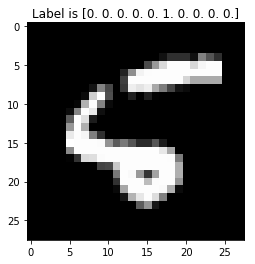

(28, 28)


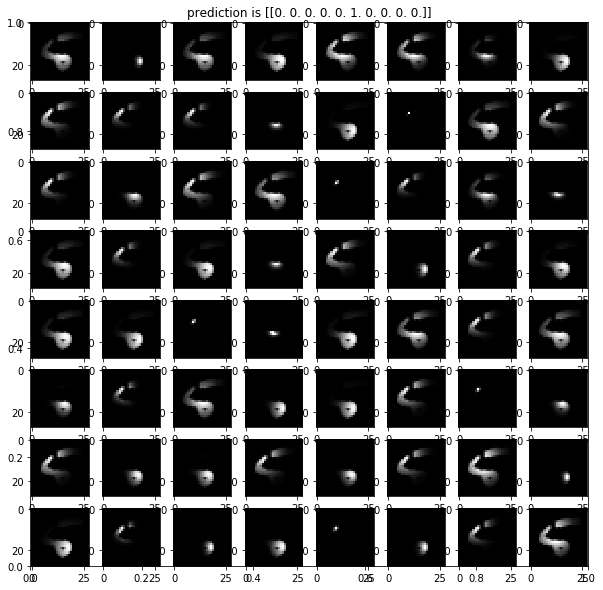

(4, 4)


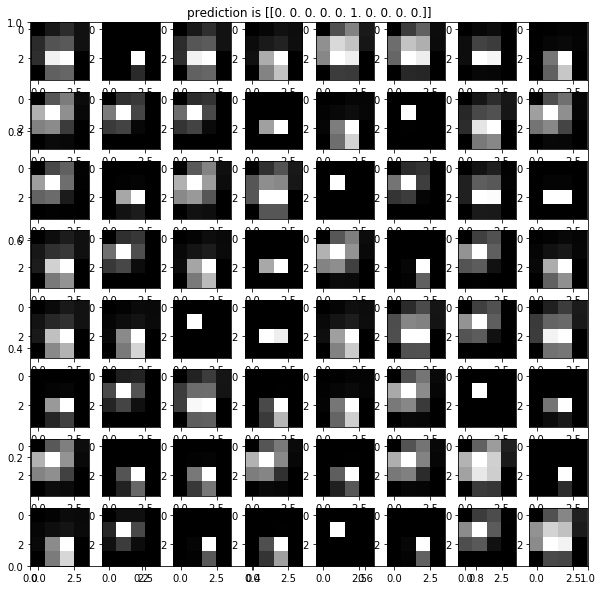

'\nattention = np.split(attention, channels, axis=-1)\nprint(np.squeeze(attention[1]).shape)\nfig = plt.figure(figsize=(10,10))\nplt.title(\'prediction is {pred}\'.format(pred=np.round(prediction)))\nfor idx in range(channels):\n    fig.add_subplot(row, col, idx + 1)\n    plt.imshow(np.squeeze(attention[idx]),cmap=\'gray\', aspect="equal")\nplt.show()\n'

In [14]:
import matplotlib.pyplot as plt
import numpy as np

num =8
sample_X = np.reshape(X_test[num], (1,28,28))
image = X_test[num]
truth = y_test[num]

row = 8
col = 8
channels = row * col

prediction, latent, pool, attention = model.predict(sample_X)

# Plot
plt.title('Label is {label}'.format(label=truth))
plt.imshow(image, cmap='gray')
plt.show()

# Plot latent space
latent = np.split(latent, channels, axis=-1)
print(np.squeeze(latent[1]).shape)
fig = plt.figure(figsize=(10,10))
plt.title('prediction is {pred}'.format(pred=np.round(prediction)))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.squeeze(latent[idx]),cmap='gray', aspect="equal")
plt.show()

# Plot pool space
pool = np.split(pool, channels, axis=-1)
print(np.squeeze(pool[1]).shape)
fig = plt.figure(figsize=(10,10))
plt.title('prediction is {pred}'.format(pred=np.round(prediction)))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.squeeze(pool[idx]),cmap='gray', aspect="equal")
plt.show()

# Plot pool space

attention = np.split(attention, channels, axis=-1)
print(np.squeeze(attention[1]).shape)
fig = plt.figure(figsize=(10,10))
plt.title('prediction is {pred}'.format(pred=np.round(prediction)))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.squeeze(attention[idx]),cmap='gray', aspect="equal")
plt.show()



In [110]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

row = np.random.normal(size=(6, 1))
row = softmax(row)
entropy = -row*np.log(row)
print(np.sum(entropy))
print(row.shape)
matrix = np.matmul(row, row.T)
print(matrix)

1.380706634029754
(6, 1)
[[0.28781042 0.037995   0.09996415 0.05007595 0.02924546 0.03138868]
 [0.037995   0.00501587 0.01319667 0.00661073 0.00386081 0.00414374]
 [0.09996415 0.01319667 0.03472018 0.0173927  0.01015772 0.01090212]
 [0.05007595 0.00661073 0.0173927  0.00871268 0.0050884  0.0054613 ]
 [0.02924546 0.00386081 0.01015772 0.0050884  0.00297174 0.00318952]
 [0.03138868 0.00414374 0.01090212 0.0054613  0.00318952 0.00342326]]


In [101]:
import keras
from keras import backend as K
from keras.layers import Layer

class PixelAttention(tf.keras.layers.Layer):
    def __init__(self, N, alpha, beta, lambd=0.01, name="stem", embed=True):
        super(PixelAttention, self).__init__()
        self.N = N
        self.alpha = alpha
        self.beta = beta
        self.lambd = lambd
        self.title = name
        self.embed = embed

    def build(self, input_shape):
        rank = len(input_shape)
        
        if rank == 3:
            self.num_pixels = int(input_shape[1])
            self.d = int(input_shape[2])
            
            print("num_pixels: ", self.num_pixels)
            print("d: ", self.d)
        
        
        
        #Learned positional encodings
        if self.embed:
            side_len = int(np.sqrt(self.num_pixels))
            pe = []
            for x in range(side_len):
                for y in range(side_len):
                    e = [] #Encoding

                    #Encode x
                    for i in range(int(max_i/2)):
                        even = np.sin(x/(np.power(10000, (2 * i) / self.d)))
                        odd = np.cos(x/(np.power(10000, (2 * i) / self.d)))
                        e.append(even)
                        e.append(odd)

                    #Encode y
                    for i in range(int(max_i/2)):
                        even = np.sin(y/(np.power(10000, (2 * i) / self.d)))
                        odd = np.cos(y/(np.power(10000, (2 * i) / self.d)))
                        e.append(even)
                        e.append(odd)
                        
                    pe.append(e)
            
            self.encodings = np.array(pe)
            
            
            
        #Multi-head Attention Variables
        WQs = []
        WKs = []
        WVs = []
        for head in range(self.N):
            #Per head Attention Variables
            WQ = self.add_variable("WQ" + str(head) + self.title, [self.d, self.alpha]
                                  ,initializer=tf.glorot_uniform_initializer)
            WK = self.add_variable("WK" + str(head) + self.title, [self.d, self.alpha]
                                  ,initializer=tf.glorot_uniform_initializer)
            WV = self.add_variable("WV" + str(head) + self.title, [self.d, self.beta]
                                  ,initializer=tf.glorot_uniform_initializer)
            
            WQs.append(WQ)
            WKs.append(WK)
            WVs.append(WV)
        
        self.WQ = tf.stack(WQs, axis=0)
        self.WK = tf.stack(WKs, axis=0)
        self.WV = tf.stack(WVs, axis=0)
            
        
        self.WF = self.add_variable("WF" + self.title, [self.beta*self.N, self.d],
                        initializer=tf.glorot_uniform_initializer)
    
        
    def call(self, input):
        b_size = tf.shape(input)[0]
        
        #get rid of this for loop
        #stack W's on axis=0, then tile embedd & input
        #reshape Z for multihead
        
        encoding = tf.matmul(self.row, self.col)
        
        WQ_tile = tf.tile(tf.expand_dims(self.WQ, axis=0), [b_size, 1, 1, 1])
        WK_tile = tf.tile(tf.expand_dims(self.WK, axis=0), [b_size, 1, 1, 1])
        WV_tile = tf.tile(tf.expand_dims(self.WV, axis=0), [b_size, 1, 1, 1])
        input_tile = tf.tile(tf.expand_dims(input, axis=1), [1, self.N, 1, 1])
        e_tile = tf.tile(tf.expand_dims(input + encoding, axis=1), [1, self.N, 1, 1])

        Q = tf.matmul(e_tile, WQ_tile)
        K = tf.reshape(tf.matmul(input_tile, WK_tile), [b_size, self.N, self.alpha, self.num_pixels])
        
        V = tf.matmul(input_tile, WV_tile)
        

        Z = tf.nn.dropout(tf.matmul(tf.nn.softmax(tf.matmul(Q, K)/tf.sqrt(float(self.alpha))), V), keep_prob=0.9)

        multi_head = tf.reshape(Z, [b_size, self.num_pixels, self.beta*self.N]) # [b_size, num_pixels, Beta * N]
        WF_tile = tf.tile(tf.expand_dims(self.WF, axis=0), [b_size, 1, 1])
        multi_head = tf.nn.dropout(tf.matmul(multi_head,WF_tile), keep_prob=0.9) #multi_head is now (num_pixels, d)

        return multi_head + input



class PA(Layer):

    def __init__(self, N, alpha, beta, lambd=0.01, name="stem", embed=True, **kwargs):
        self.N = N
        self.alpha = alpha
        self.beta = beta
        self.lambd = lambd
        self.title = name
        self.embed = embed
        
        super(PA, self).__init__(**kwargs)

    def build(self, input_shape):
        rank = len(input_shape)
        
        if rank == 3:
            self.num_pixels = int(input_shape[1])
            self.d = int(input_shape[2])
            
            print("num_pixels: ", self.num_pixels)
            print("d: ", self.d)
        
        
        
        #Learned positional encodings
        if self.embed:
            max_i = int(self.d/2)
            side_len = int(np.sqrt(self.num_pixels))
            pe = []
            for x in range(side_len):
                for y in range(side_len):
                    e = [] #Encoding

                    #Encode x
                    for i in range(int(max_i/2)):
                        even = np.sin(x/(np.power(10000, (2 * i) / self.d)))
                        odd = np.cos(x/(np.power(10000, (2 * i) / self.d)))
                        e.append(even)
                        e.append(odd)

                    #Encode y
                    for i in range(int(max_i/2)):
                        even = np.sin(y/(np.power(10000, (2 * i) / self.d)))
                        odd = np.cos(y/(np.power(10000, (2 * i) / self.d)))
                        e.append(even)
                        e.append(odd)
                        
                    pe.append(e)
            
            self.encodings = np.array(pe, dtype=np.float32)
            
            
            
        #Multi-head Attention Variables
        WQs = []
        WKs = []
        WVs = []
        for head in range(self.N):
            #Per head Attention Variables
            WQ = self.add_weight(name="WQ" + str(head) + self.title, 
                                 shape=(self.d, self.alpha),
                                 initializer='glorot_uniform',
                                trainable=True)
            
            WK = self.add_weight(name="WK" + str(head) + self.title, 
                                 shape=(self.d, self.alpha),
                                 initializer='glorot_uniform',
                                trainable=True)
            WV = self.add_weight(name="WV" + str(head) + self.title, 
                                 shape=(self.d, self.beta),
                                 initializer='glorot_uniform',
                                trainable=True)
            
            WQs.append(WQ)
            WKs.append(WK)
            WVs.append(WV)
        
        self.WQ = K.stack(WQs, axis=0)
        #print("WQ no tile: ", self.WQ)
        self.WK = K.stack(WKs, axis=0)
        self.WV = K.stack(WVs, axis=0)
            
        
        self.WF = self.add_weight(name="WV" + str(head) + self.title, 
                                 shape=(self.beta*self.N, self.d),
                                 initializer='glorot_uniform',
                                trainable=True)
        
        super(PA, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        input = x
        
        
        b_size = K.shape(input)[0]
        
        #get rid of this for loop
        #stack W's on axis=0, then tile embedd & input
        #reshape Z for multihead
        
        
        
        WQ_tile = K.tile(K.expand_dims(K.tile(K.expand_dims(self.WQ, axis=0), (b_size, 1, 1, 1)), axis=2), (1, 1, self.num_pixels, 1, 1))
        WK_tile = K.tile(K.expand_dims(K.tile(K.expand_dims(self.WK, axis=0), (b_size, 1, 1, 1)), axis=2), (1, 1, self.num_pixels, 1, 1))
        WV_tile = K.tile(K.expand_dims(K.tile(K.expand_dims(self.WV, axis=0), (b_size, 1, 1, 1)), axis=2), (1, 1, self.num_pixels, 1, 1))
        
        
        #print(WQ_tile)
        
        if self.embed:
            encoding = self.encodings
            encoding = K.tile(K.expand_dims(encoding, axis=0), (b_size, 1, 1))
            print(encoding)
            
            query = K.reshape(input + encoding, (b_size, self.num_pixels, 1, self.d))
            M = K.tile(K.expand_dims(input + encoding, axis=1), (1, self.num_pixels, 1, 1)) #change this when we create random croppings to make speedup possible
            print(query)
            print(M)
            #M -> (b_size, self.num_pixels, self.num_pixels, d)
            input_tile = K.tile(K.expand_dims(query, axis=1), (1, self.N, 1, 1, 1)) #Query vector!, maybe another dim is needed?
            #print(input_tile)
            e_tile = K.tile(K.expand_dims(M, axis=1), (1, self.N, 1, 1, 1)) #Memory matrix ... add dim??
        else:
            #memory = K.reshape(input, (b_size, ) ... q - > (b_size, self.num_pixels, 1, d)
            
            query = K.reshape(input, (b_size, self.num_pixels, 1, self.d))
            M = K.tile(K.expand_dims(input, axis=1), (1, self.num_pixels, 1, 1)) #change this when we create random croppings to make speedup possible
            #print(query)
            #print(M)
            #M -> (b_size, self.num_pixels, self.num_pixels, d)
            input_tile = K.tile(K.expand_dims(query, axis=1), (1, self.N, 1, 1, 1)) #Query vector!, maybe another dim is needed?
            #print(input_tile)
            e_tile = K.tile(K.expand_dims(M, axis=1), (1, self.N, 1, 1, 1)) #Memory matrix ... add dim??
            #print(e_tile)
        #print(input_tile)
        #print(e_tile)
        #print(WQ_tile)
        #print(WK_tile)
        #print(WV_tile)

        Q = K.batch_dot(input_tile, WQ_tile)
        #print(Q)
        Kv = K.reshape(K.batch_dot(e_tile, WK_tile), (b_size, self.N, self.num_pixels, self.alpha, self.num_pixels))
        print(Kv)
        
        V = K.batch_dot(e_tile, WV_tile)
        print(V)
        
        preZ = K.softmax(K.batch_dot(Q, Kv)/np.sqrt(float(self.alpha)), axis=-1)
        Z = K.dropout(K.batch_dot(preZ, V), 0.1)
        
        multi_head = K.reshape(Z, (b_size, self.num_pixels, self.beta*self.N)) # [b_size, num_pixels, Beta * N]
        WF_tile = K.tile(K.expand_dims(self.WF, axis=0), (b_size, 1, 1))
        
        multi_head = K.dropout(K.batch_dot(multi_head,WF_tile), 0.1) #multi_head is now (b_size, num_pixels, d)

        return multi_head + input
    
    
    def compute_output_shape(self, input_shape):
        return input_shape

num_pixels:  256
d:  4
Tensor("pa_1/Tile_6:0", shape=(?, 256, 4), dtype=float32)
Tensor("pa_1/Reshape:0", shape=(?, 256, 1, 4), dtype=float32)
Tensor("pa_1/Tile_7:0", shape=(?, 256, 256, 4), dtype=float32)
Tensor("pa_1/Reshape_1:0", shape=(?, 1, 256, 4, 256), dtype=float32)
Tensor("pa_1/MatMul_2:0", shape=(?, 1, 256, 256, 4), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 4)    16        

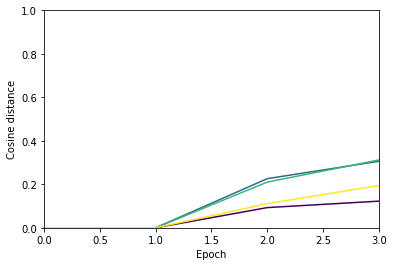

In [129]:
### import keras
import matplotlib.pyplot as plt

from keras.regularizers import l1

from layer_rotation_control import SGD, Adagrad, Adam
from layer_rotation_monitoring import LayerRotationCurves

def pixel_layer(X, N, alpha, beta, d, dim):
    re = keras.layers.Reshape((int(dim*dim), d))(X)
    att = PA(N, alpha, beta, embed=True)(re)
    att = keras.layers.Reshape((dim, dim, d))(att)
    att = keras.layers.BatchNormalization(axis=-1)(att)
    c = keras.layers.Conv2D(4*d, 1)(att)
    c = keras.layers.Activation("relu")(c)
    c = keras.layers.Conv2D(d, 1)(c)
    c = keras.layers.Add()([c, att])
    c = keras.layers.BatchNormalization(axis=-1)(c)
    
    return c

#p1 = pixel_layer(conv, N, alpha, beta, filt)
# load MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
# scale all input values between 0 and 1
# This is normalizes the data and reduces the amount of variance in gray color 
X_train = X_train /255.
X_test = X_test / 255.

keras.backend.clear_session()

#hyperparameters
N = 1
alpha = 4
beta = 4

Nx = 1

filt = 4
dim = int(2)
# define our model
inputs = keras.layers.Input(shape=(32,32,3))

pool = keras.layers.MaxPool2D(pool_size=(dim,dim))(inputs)
preshape = keras.layers.Conv2D(filt, 1)(pool)

p = pixel_layer(preshape, N, alpha, beta, filt, int(32/dim))

for _ in range(int(Nx - 1)):
    p = pixel_layer(p, N, alpha, beta, filt)
    
#downscale = keras.layers.Conv2D(8, 1)(p)

x = keras.layers.Flatten()(p)
output = keras.layers.Dense(10, activation='softmax', kernel_regularizer=l1(0.0))(x)

model = keras.Model(inputs=inputs,outputs=[output, pool, p])


lr = 3**-3
opt = Adam(lr,layca = True)

# a keras callback to record layer rotation
lrc = LayerRotationCurves()
model.compile(optimizer=opt, loss=["sparse_categorical_crossentropy", None, None], metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_test,y_test), callbacks = [lrc])

# plot layer rotation curves
plt.figure()
lrc.plot()

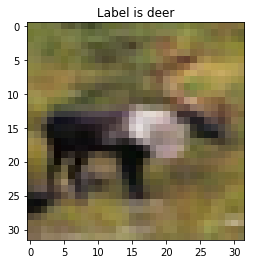

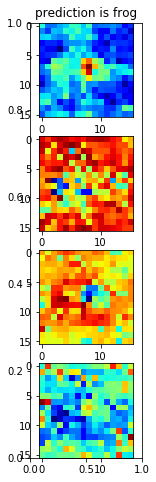

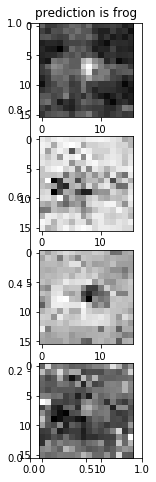

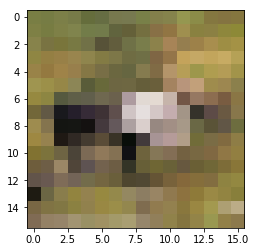

In [132]:
#p1 = pixel_layer(conv, N, alpha, beta, filt)
# load MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
# scale all input values between 0 and 1
# This is normalizes the data and reduces the amount of variance in gray color 
X_train = X_train /255.
X_test = X_test / 255.

def pred_to_num(pred):
    index = 0
    for num in pred:
        if num == 1:
            return index
        index += 1

cif_class = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

import matplotlib.pyplot as plt
import numpy as np

num = np.random.choice(10000)
sample_X = np.reshape(X_test[num], (1,32,32,3))
image = X_test[num]
truth = np.squeeze(y_test[num])

row = 1
col = 4
channels = row * col

prediction, conv1, conv3 = model.predict(sample_X)
# Plot
plt.title('Label is {label}'.format(label=cif_class[truth]))
plt.imshow(image)
plt.show()

"""
# Plot conv1 activations
c = np.split(conv1, channels, axis=-1)
fig = plt.figure(figsize=(col*2,row*2))
plt.title('prediction is {pred}'.format(pred=cif_class[np.argmax(prediction)]))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.reshape(c[idx], (16,16)),cmap='jet', aspect="equal")
plt.show()

fig = plt.figure(figsize=(col*2,row*2))
plt.title('prediction is {pred}'.format(pred=cif_class[np.argmax(prediction)]))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.reshape(c[idx], (16,16)),cmap='gray', aspect="equal")
plt.show()
"""

"""
# Plot conv1 activations
c = np.split(conv2, channels, axis=-1)
fig = plt.figure(figsize=(col*2,row*2))
plt.title('prediction is {pred}'.format(pred=cif_class[np.argmax(prediction)]))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.reshape(c[idx], (16,16)),cmap='jet', aspect="equal")
plt.show()

fig = plt.figure(figsize=(col*2,row*2))
plt.title('prediction is {pred}'.format(pred=cif_class[np.argmax(prediction)]))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.reshape(c[idx], (16,16)),cmap='gray', aspect="equal")
plt.show()
"""

# Plot conv1 activations
c = np.split(conv3, channels, axis=-1)
fig = plt.figure(figsize=(col*2,row*2))
plt.title('prediction is {pred}'.format(pred=cif_class[np.argmax(prediction)]))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.reshape(c[idx], (int(32/dim),int(32/dim))),cmap='jet', aspect="equal")
plt.show()

fig = plt.figure(figsize=(col*2,row*2))
plt.title('prediction is {pred}'.format(pred=cif_class[np.argmax(prediction)]))
for idx in range(channels):
    fig.add_subplot(row, col, idx + 1)
    plt.imshow(np.reshape(c[idx], (int(32/dim),int(32/dim))),cmap='gray', aspect="equal")
plt.show()
#plt.imshow(conv3[0])
#plt.show()


plt.imshow(conv1[0])
plt.show()


In [124]:
#Lets do some unsupervised learning

tf.keras.backend.clear_session()
#hyperparameters
N = 8
alpha = 64
beta = 64

Nx = 1
# define our model
inputs = tf.keras.layers.Input(shape=(28,28))
reshape = tf.keras.layers.Reshape((28,28,1))(inputs)
pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(reshape)
reshape_ = tf.keras.layers.Reshape((196, 1))(pool)
p_atten = PixelAttention(N, alpha, beta)(reshape_)
x = tf.keras.layers.Flatten()(p_atten)

latent = tf.keras.layers.Dense(5, activation="linear")(x)
    

output = tf.keras.layers.Dense(784, activation='sigmoid')(latent)

model = tf.keras.Model(inputs=inputs,outputs=[output, p_atten])

model.compile(optimizer="adam", loss=["mean_squared_error", None])
model.summary()
model.fit(X_train, np.reshape(X_train, (-1, 784)), epochs=3)

num_pixels:  196
d:  1


AttributeError: 'PixelAttention' object has no attribute 'row'

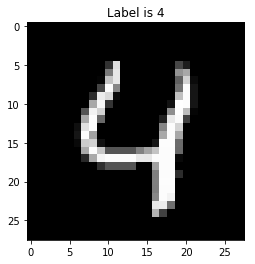

(28, 28)


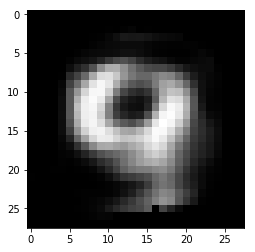

(14, 14)


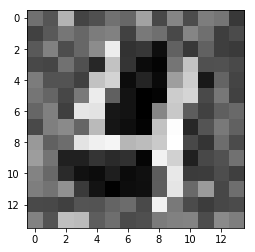

In [34]:
def pred_to_num(pred):
    index = 0
    for num in pred:
        if num == 1:
            return index
        index += 1

import matplotlib.pyplot as plt
import numpy as np

num =4
sample_X = np.reshape(X_test[num], (1,28,28))
image = X_test[num]
truth = y_test[num]

row = 8
col = 8
channels = row * col

pred, p_atten = model.predict(sample_X)

# Plot
plt.title('Label is {label}'.format(label=pred_to_num(truth)))
plt.imshow(image, cmap='gray')
plt.show()

"""
#Plot maxpool
plt.title('Label is {label}'.format(label=pred_to_num(truth)))
pool = np.reshape(pool, (14,14))
print(pool.shape)
plt.imshow(pool, cmap="gray")
plt.show()
"""

# Plot latent space
pred = np.reshape(pred, (28, 28))
print(pred.shape)
plt.imshow(pred, cmap="gray")
plt.show()

p_atten = np.reshape(p_atten, (14, 14))
print(p_atten.shape)
plt.imshow(p_atten, cmap="gray")
plt.show()



